# Dispersion Analysis: Fornberg vs. DRP Stencils

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from functools import partial
from matplotlib import patheffects
from numpy import linalg as la
import segyio
import sys
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import RectBivariateSpline

In [2]:
from devito import Grid, Function, TimeFunction, SparseTimeFunction, Eq, Operator, solve

In [3]:
normtype  = np.inf

## 1. Problem Setup

In [4]:
def ricker(t, f):
    
    val1 = 1-2*((np.pi*f)*(t-1/f))**2
    val2 = -((np.pi*f)**2*(t-1/f)**2)
    val3 = val1*np.exp(val2)

    return val3

In [5]:
f0       = 0.02
npoints  = 101
extent   = 1000
h        = extent/(npoints-1)
t1       = 300
vvel     = 1.5*np.ones((npoints,npoints))
vmax     = np.amax(vvel)

In [6]:
def critical_dt(weights,h,vmax):
    
    a = h*np.sqrt(2/np.sum([np.abs(a) for a in weights]))/vmax
    
    return float(a)

In [7]:
def critical_h(weights,dt,vmax):

    a = float(np.sqrt(2/np.sum([np.abs(a) for a in weights]))/(vmax*dt))
    b = 1/a
    
    return b

In [8]:
def acoustic(weightsx,weightsy,hx,hy,dt,vmodel,f,extentx,extenty,t1,factor=1):

    origin = (0., 0.)
    grid_extent = (extentx, extenty)
    snx = int(np.ceil((grid_extent[0] - origin[0])/hx))
    sny = int(np.ceil((grid_extent[1] - origin[1])/hy))
    shape = (snx, sny)
    
    t0 = 0
    tn = int(np.ceil((t1 - t0)/dt))

    vmax = np.amax(vmodel)
    
    r = vmax*dt/min(hx,hy)

    weightsx = np.concatenate([weightsx[::-1], weightsx[1:]])
    weightsy = np.concatenate([weightsy[::-1], weightsy[1:]])
    space_order = len(weightsx) - 1

    sx = grid_extent[0]/2 - origin[0]
    sy = grid_extent[1]/2 - origin[1]

    grid = Grid(shape=shape, extent=grid_extent)
    x, y = grid.dimensions

    velocity = Function(name="velocity", grid=grid, space_order=space_order)
    
    if(factor!=1):

        xoriginal        = np.linspace(0, extentx, vmodel.shape[0])
        yoriginal        = np.linspace(0, extenty, vmodel.shape[1])
        interp_spline    = RectBivariateSpline(xoriginal, yoriginal, vmodel)
        xx               = np.linspace(0, extentx, snx)
        yy               = np.linspace(0, extenty, sny)        
        vvelinterp       = interp_spline(xx, yy)
        velocity.data[:] = vvelinterp[:]

    else:

        velocity.data[:] = vmodel[:]

    
    t = np.linspace(t0, t1, tn)
    source = SparseTimeFunction(
        name="ricker",
        npoint=1,
        coordinates=[(sx, sy)],
        nt=tn,
        grid=grid,
        time_order=2,
        space_order=space_order
    )
    source.data[:, 0] = ricker(t,f=f)

    nrecv = vmodel.shape[0]
    rx = np.linspace(origin[0], grid_extent[0], nrecv)
    ry = (grid_extent[1]/2 - origin[1])*np.ones(nrecv)
    
    receiver = SparseTimeFunction(
        name="recv",
        npoint=nrecv,
        coordinates=np.array([rx, ry]).T,
        nt=tn,
        grid=grid
    )

    u = TimeFunction(name="u", grid=grid, time_order=2, space_order=space_order)

    pde = (1/velocity**2)*u.dt2 - u.dx2(weights=weightsx) - u.dy2(weights=weightsy)

    stencil = Eq(u.forward, solve(pde, u.forward))
    
    src_term = source.inject(field=u.forward, expr=source*factor*factor*velocity*velocity*dt*dt)
    recv_term = receiver.interpolate(expr=u.forward)
    op = Operator([stencil] + src_term + recv_term, subs=grid.spacing_map)
    op(time=tn - 1, dt=dt)
    
    return u.data[-1], receiver.data, r

In [9]:
def critical_cfl(weights,h,dt,vmax):

    limit  = np.sqrt(2/np.sum([np.abs(a) for a in weights]))
    rvalue = (dt*vmax)/h

    print('Limit Value: %f'%limit)
    print('RVALUE: %f'%rvalue)
    
    if(limit>rvalue): 
        
        print('Stable Choice of weights,h,dt and vel!')
        print('')

    else:

        print('WARNING!"')
        print('Unstable Choice of weights, h,dt and vel!')
        print('')
        
    return

In [10]:
M = 20
x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
N = 2
weightsteste  = sym.finite_diff_weights(N, x, 0)
fornbergteste = np.array(weightsteste[-1][-1][::2], dtype=np.float64)

In [11]:
dtinitial = critical_dt(fornbergteste,h,vmax)

In [12]:
dtinitial

3.932985788237516

In [13]:
dtnew = 0.5*dtinitial

In [14]:
dtnew

1.966492894118758

In [15]:
critical_cfl(fornbergteste,0.1*h,dtnew,vmax)

Limit Value: 0.589948
RVALUE: 2.949739
WARNING!"
Unstable Choice of weights, h,dt and vel!



In [16]:
factor = 0.9
hteste = factor*h

In [17]:
uteste,datateste,rteste = acoustic(fornbergteste,fornbergteste,hteste,hteste,dtnew,vvel,f0,extent,extent,t1,factor=factor)

Operator `Kernel` ran in 0.01 s


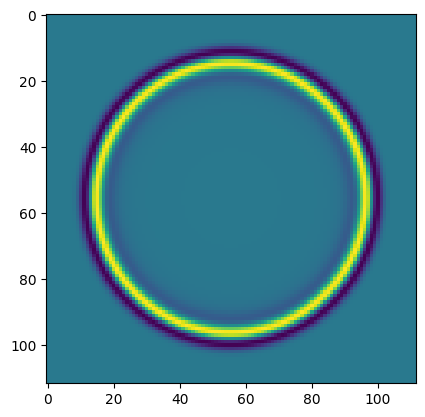

In [18]:
plt.imshow(np.transpose(uteste))

In [19]:
vh     = np.linspace(0.1*h,h,10)
nvh    = vh.shape[0]
morder = 8

## 2. Fornberg

In [20]:
lnormuf   = []

for k1 in range(0,nvh):
    
    try:
    
        M = morder
        x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
        N = 2
        weights     = sym.finite_diff_weights(N, x, 0)
        fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
        hloc        = vh[k1] 
        factor      = h/hloc
        uf,dataf,rf = acoustic(fornberg,fornberg,hloc,hloc,dtnew,vvel,f0,extent,extent,t1,factor=factor)

        lnormu = la.norm(uf,normtype)
        lnormuf.append(lnormu)

    except:
        
            lnormuf.append(lnormu)

Operator `Kernel` ran in 0.18 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.02 s
Operator `Kernel` ran in 0.02 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


In [21]:
lnormuf1 = lnormuf
compfact = 5
for k1 in range(0,nvh-1):

    if(lnormuf1[k1]>compfact*lnormuf1[-1]): lnormuf1[k1] = np.nan

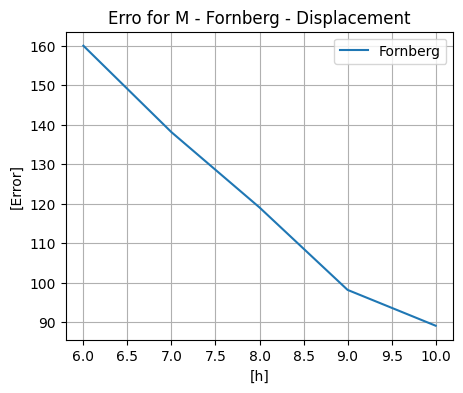

In [22]:
plt.figure(figsize = (5,4))
plt.plot(vh,lnormuf,label='Fornberg')
plt.grid()
plt.legend()
plt.title('Erro for M - Fornberg - Displacement')
plt.xlabel('[h]')
plt.ylabel('[Error]')
plt.show()

## 3. DPRS - Method 1

In [23]:
def objective(a):
    x = np.linspace(0, np.pi/2, 201)
    m = np.arange(1, len(a) + 1)
    y = x**2 + a[0] + 2*np.sum([a_ * np.cos(m_*x) for a_, m_ in zip(a[1:], m)], axis=0)
    return sp.integrate.trapezoid(y**2, x=x)

In [24]:
lnormudrp1   = []

for k1 in range(0,nvh):

    try:
    
        M = morder
        x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
        N = 2
        weights     = sym.finite_diff_weights(N, x, 0)
        fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
        
        initial_guess = fornberg
        
        constraints = [{
            'type': 'eq',
            'fun': lambda x: x[0] + 2*np.sum(x[1:])
        }]
        constraints += [{
            'type': 'eq',
            'fun': lambda x: np.sum([xi*m**2 for m, xi in enumerate(x)]) - 1
        }]
        constraints += [{
            'type': 'eq',
            'fun': lambda x: np.sum([xi*m**(2*jj) for m, xi in enumerate(x)])
        } for jj in range(2, (len(initial_guess) + 1)//2)]

        hloc        = vh[k1] 
        factor      = h/hloc
        opt1 = sp.optimize.minimize(objective, initial_guess, method='SLSQP', constraints=constraints, options=dict(ftol=1e-15, maxiter=500))
        drp_stencil1 = opt1.x
        uf,dataf,rf  = acoustic(drp_stencil1,drp_stencil1,hloc,hloc,dtnew,vvel,f0,extent,extent,t1,factor=factor)
    
        lnormu = la.norm(uf,normtype)
        lnormudrp1.append(lnormu)
    
    except:
    
        lnormudrp1.append(np.nan)

Operator `Kernel` ran in 0.18 s
Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.02 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


In [25]:
lnormudrp11 = lnormudrp1
compfact = 5
for k1 in range(0,nvh-1):

    if(lnormudrp11[k1]>compfact*lnormudrp11[-1]): lnormudrp11[k1] = np.nan

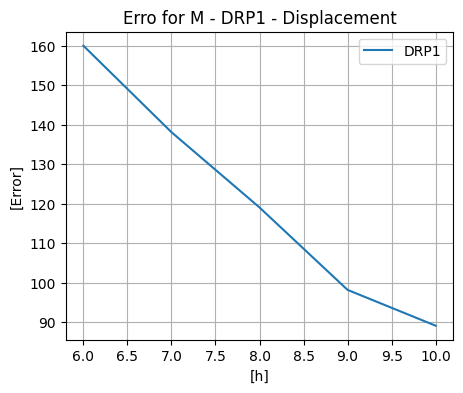

In [26]:
plt.figure(figsize = (5,4))
plt.plot(vh,lnormudrp11,label='DRP1')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP1 - Displacement')
plt.xlabel('[h]')
plt.ylabel('[Error]')
plt.show()

In [35]:
lnormudrp11

[np.float32(nan),
 np.float32(nan),
 np.float32(nan),
 np.float32(nan),
 np.float32(nan),
 np.float32(159.95755),
 np.float32(138.0759),
 np.float32(119.01582),
 np.float32(98.15343),
 np.float32(89.08609)]

## 4.DRPS - Method 2

In [27]:
def dispersion_difference(weights,h,dt,v,k,alpha):
    if k == 0:
        diff = 0
    else:
        m = len(weights)
        cosines = np.array([
            np.cos(m*k*h*np.cos(alpha)) + np.cos(m*k*h*np.sin(alpha)) - 2
            for m in range(1, m)
        ])
        total = np.sum(np.array(weights)[1:]*cosines)
        theta = 1 + (v**2)*(dt**2)*total/(h**2)
        valloc = np.acos(theta)

        if(np.isnan(valloc)==True):

            sys.exit('NAV!')
        else:
        
            diff = np.abs(np.acos(theta)/(k*dt) - v)
        
        #diff = np.abs(np.acos(theta)/(k*dt) - v)
    return diff

In [28]:
def objective2(a, h, dt, fmax=100, vmin=np.amin(vvel), vmax=np.amax(vvel), alphamin=0, alphamax=np.pi/4, res=31):
    diff_wrapper = partial(dispersion_difference, weights=a, h=h, dt=dt)

    k_integral = np.zeros(res)
    v_space = np.linspace(vmin, vmax, res)
    alpha_space = np.linspace(alphamin, alphamax, res)
    for ii, v in enumerate(v_space):
        alpha_integral = np.zeros(res)
        k_space = np.linspace(0, 2*np.pi*fmax/v, res)
        for jj, k in enumerate(k_space):
            alpha_data = np.array([
                diff_wrapper(alpha=alpha, k=k, v=v) for alpha in alpha_space
            ])
            alpha_integral[jj] = np.trapezoid(alpha_data, alpha_space)
        k_integral[ii] = np.trapezoid(alpha_integral, k_space)
    v_integral = np.trapezoid(k_integral, v_space)

    return v_integral

In [29]:
lnormudrp2   = []

for k1 in range(0,nvh):

    try:
    
        M = morder
        x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
        N = 2
        weights     = sym.finite_diff_weights(N, x, 0)
        fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)

        hloc        = vh[k1] 
        factor      = h/hloc
        initial_guess = fornberg
        objective2_wrapper = partial(objective2, h=hloc, dt=dtnew)
        opt2 = sp.optimize.minimize(objective2_wrapper, initial_guess, constraints=constraints, method='SLSQP')
        drp_stencil2 = opt2.x
        uf,dataf,rf = acoustic(drp_stencil2,drp_stencil2,h,h,dtnew,vvel,f0,extent,extent,t1,factor=factor)
    
        lnormu = la.norm(uf,normtype)   
        lnormudrp2.append(lnormu)
    
    except:
    
        lnormudrp2.append(np.nan)

/tmp/ipykernel_424742/768453969.py:12: RuntimeWarning: invalid value encountered in arccos
  valloc = np.acos(theta)
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


In [30]:
lnormudrp21 = lnormudrp2
compfact = 5
for k1 in range(0,nvh-1):

    if(lnormudrp21[k1]>compfact*lnormudrp21[-1]): lnormudrp21[k1] = np.nan

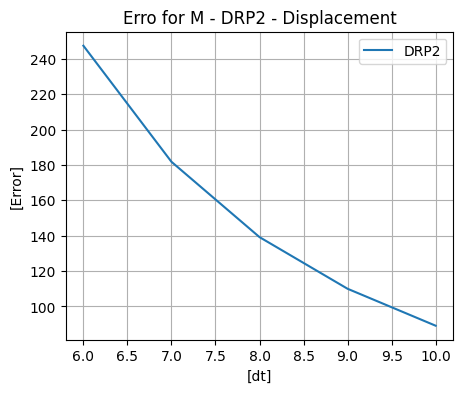

In [31]:
plt.figure(figsize = (5,4))
plt.plot(vh,lnormudrp21,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP2 - Displacement')
plt.xlabel('[dt]')
plt.ylabel('[Error]')
plt.show()

## 5. Comparison

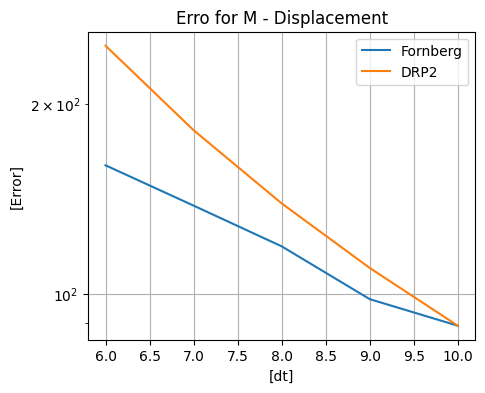

In [32]:
plt.figure(figsize = (5,4))
plt.plot(vh,lnormuf,label='Fornberg')
# plt.plot(vh,lnormudrp1,label='DRP1')
plt.plot(vh,lnormudrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - Displacement')
plt.xlabel('[dt]')
plt.ylabel('[Error]')
plt.yscale('log')
plt.show()

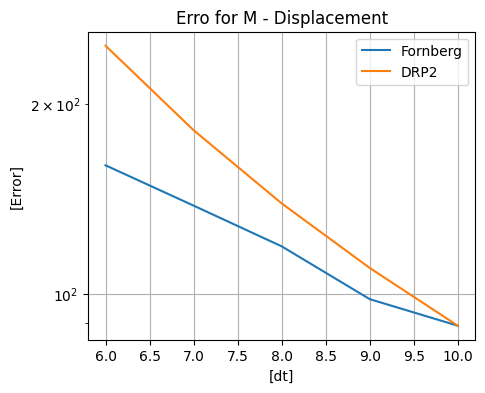

In [33]:
plt.figure(figsize = (5,4))
plt.plot(vh,lnormuf,label='Fornberg')
plt.plot(vh,lnormudrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - Displacement')
plt.xlabel('[dt]')
plt.ylabel('[Error]')
plt.yscale('log')
plt.show()

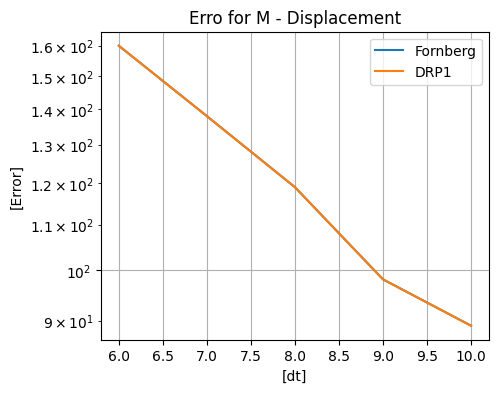

In [34]:
plt.figure(figsize = (5,4))
plt.plot(vh,lnormuf,label='Fornberg')
plt.plot(vh,lnormudrp1,label='DRP1')
plt.grid()
plt.legend()
plt.title('Erro for M - Displacement')
plt.xlabel('[dt]')
plt.ylabel('[Error]')
plt.yscale('log')
plt.show()